In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [60]:
data = pd.read_csv('./dataset/clean_weather.csv')
data = data.ffill()

# Display a sequence of temperatures
data["tmax"].head(10)

0    60.0
1    52.0
2    52.0
3    53.0
4    52.0
5    50.0
6    52.0
7    56.0
8    54.0
9    57.0
Name: tmax, dtype: float64

### Forward Pass

In [61]:
# Set a random seed so the random numbers are the same every time
np.random.seed(0)
# Take the input number and turn it into 2 features
i_weight = np.random.rand(1,2)
# Hidden to hidden weight connection - 2 features to 2 features
h_weight = np.random.rand(2,2)
# Output weight connection - turn 2 features into one prediction
o_weight = np.random.rand(2,1)

# Get 3 temperature values from our data
temps = data["tmax"].tail(3).to_numpy()
temps

array([66., 70., 62.])

In [62]:
x0 = temps[0].reshape(1,1)
x1 = temps[1].reshape(1,1)
x2 = temps[2].reshape(1,1)

In [63]:
xi_0 = x0 @ i_weight
xi_0

array([[36.22169126, 47.20249818]])

In [64]:
xh_0 = np.maximum(0, xi_0)
xh_0

array([[36.22169126, 47.20249818]])

In [65]:
xo_0 = xh_0 @ o_weight
xo_0

array([[57.94406231]])

Time stamp 1

In [66]:
xi_1 = x1 @ i_weight

xh = xh_0 @ h_weight
xh_1 = np.maximum(0, xh)

xo_1 = xh_1 @ o_weight
xo_1

array([[63.09333726]])

Time stamp 2

In [67]:
xi_2 = x2 @ i_weight

xh = xh_1 @ h_weight
xh_2 = np.maximum(0, xh)

xo_2 = xh_2 @ o_weight
xo_2

array([[69.59905447]])

### Tanh activation

$$\tanh = \dfrac{e^{x}-e^{-x}}{e^{x}+e^{-x}}$$

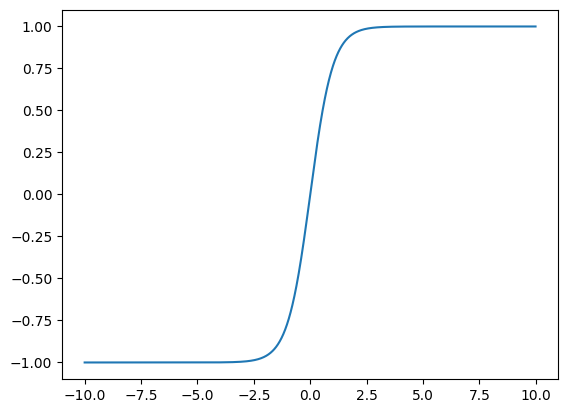

In [68]:
# graph of tanh

temps = np.arange(-10, 10, 0.01)
tanh = np.tanh(temps)

plt.plot(temps, tanh)
plt.show()

In [69]:
# derrivative of tanh
from sympy import diff, symbols, exp

x = symbols('x')
sympy_tanh = (exp(x) - exp(-x)) / (exp(x) + exp(-x))

diff(sympy_tanh, x)

(-exp(x) + exp(-x))*(exp(x) - exp(-x))/(exp(x) + exp(-x))**2 + 1

$1-\tanh^2x$

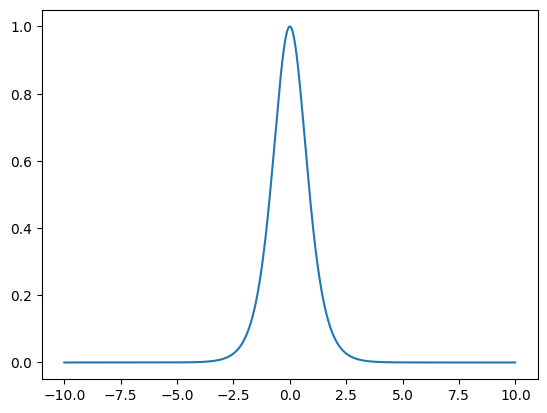

In [70]:
# plotting the derivative of tanh
plt.plot(temps, 1-np.tanh(temps)**2)
plt.show()

### Full forward pass

![fp](ref_images\rnn_operations.svg)

In [71]:
np.random.seed(0)

# Define our weights and biases
# Scale them down so values get through the tanh nonlinearity
i_weight = np.random.rand(1,5) / 5 - .1
h_weight = np.random.rand(5,5) / 5 - .1
h_bias = np.random.rand(1,5) / 5 - .1

# Tanh pushes values to between -1 and 1, so scale up the output weights
o_weight = np.random.rand(5,1) * 50
o_bias = np.random.rand(1,1)

In [72]:
# An array to store the output predictions
outputs = np.zeros(3)
# An array to store hidden states for use in backpropagation
hiddens = np.zeros((3, 5))

# This will store the previous hidden state, since we'll need it to calculate the current hidden step
prev_hidden = None
sequence = data["tmax"].tail(3).to_numpy()

for i in range(3):
    # Get the input sequence at the given position
    x = sequence[i].reshape(1,1)

    # Multiply input by input weight
    xi = x @ i_weight
    if prev_hidden is not None:
        # Add previous hidden to input
        xh = xi + prev_hidden @ h_weight + h_bias
    else:
        xh = xi

    # Apply our activation function
    xh = np.tanh(xh)
    prev_hidden = xh
    hiddens[i,] = xh

    # Multiply by the output weight
    xo = xh @ o_weight + o_bias
    outputs[i] = xo

C:\Users\blood\AppData\Local\Temp\ipykernel_3704\1174838102.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  outputs[i] = xo


### Backward Pass

![BP](ref_images\rnn_operations_bw.svg)

In [73]:
def mse(actual, predicted):
    return np.mean((actual - predicted)**2)

def mse_grad(actual, predicted):
    return (predicted - actual)

In [74]:
actuals = np.array([78, 62, 65])

loss_grad = mse_grad(actuals, outputs)
loss_grad

array([-3.68529405, 18.66149404, 12.67852446])

In [75]:
next_hidden = None

o_weight_grad, o_bias_grad, h_weight_grad, h_bias_grad, i_weight_grad = [0] * 5

for i in range(2, -1, -1):
    l_grad = loss_grad[i].reshape(1,1)

    o_weight_grad += hiddens[i][:,np.newaxis] @ l_grad
    o_bias_grad += np.mean(l_grad)

    o_grad = l_grad @ o_weight.T

    # Only add in the hidden gradient if a next sequence exists
    if next_hidden is not None:
        h_grad = o_grad + next_hidden @ h_weight.T
    else:
        h_grad = o_grad

    tanh_deriv = 1 - hiddens[i,:][np.newaxis,:] ** 2
    h_grad = np.multiply(h_grad, tanh_deriv)

    next_hidden = h_grad

    # Don't update the hidden weights for the first sequence position
    if i > 0:
        h_weight_grad += hiddens[i-1,:][:,np.newaxis] @ h_grad
        h_bias_grad += np.mean(h_grad)

    i_weight_grad += sequence[i].reshape(1,1).T @ h_grad

In [76]:
i_weight_grad

array([[43450.85913235,   708.04215267, 12456.81850796, 48281.59595466,
        19821.7046817 ]])

### Full Implementation

In [79]:
from sklearn.preprocessing import StandardScaler
import math

# Define predictors and target
PREDICTORS = ["tmax", "tmin", "rain"]
TARGET = "tmax_tomorrow"

# Scale our data to have mean 0
scaler = StandardScaler()
data[PREDICTORS] = scaler.fit_transform(data[PREDICTORS])

# Split into train, valid, test sets
np.random.seed(0)
split_data = np.split(data, [int(.7*len(data)), int(.85*len(data))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [[d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()] for d in split_data]

e:\anyai\lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [80]:
def init_params(layer_conf):
    layers = []
    for i in range(1, len(layer_conf)):
        np.random.seed(0)
        k = 1/math.sqrt(layer_conf[i]["hidden"])
        i_weight = np.random.rand(layer_conf[i-1]["units"], layer_conf[i]["hidden"]) * 2 * k - k

        h_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["hidden"]) * 2 * k - k
        h_bias = np.random.rand(1, layer_conf[i]["hidden"]) * 2 * k - k

        o_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["output"]) * 2 * k - k
        o_bias = np.random.rand(1, layer_conf[i]["output"]) * 2 * k - k

        layers.append(
            [i_weight, h_weight, h_bias, o_weight, o_bias]
        )
    return layers

In [81]:
def forward(x, layers):
    hiddens = []
    outputs = []
    for i in range(len(layers)):
        i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
        hidden = np.zeros((x.shape[0], i_weight.shape[1]))
        output = np.zeros((x.shape[0], o_weight.shape[1]))
        for j in range(x.shape[0]):
            input_x = x[j,:][np.newaxis,:] @ i_weight
            hidden_x = input_x + hidden[max(j-1,0),:][np.newaxis,:] @ h_weight + h_bias
            # Activation.  tanh avoids outputs getting larger and larger.
            hidden_x = np.tanh(hidden_x)
            # Store hidden for use in backprop
            hidden[j,:] = hidden_x

            # Output layer
            output_x = hidden_x @ o_weight + o_bias
            output[j,:] = output_x
        hiddens.append(hidden)
        outputs.append(output)
    return hiddens, outputs[-1]

In [82]:
def backward(layers, x, lr, grad, hiddens):
    for i in range(len(layers)):
        i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
        hidden = hiddens[i]
        next_h_grad = None
        i_weight_grad, h_weight_grad, h_bias_grad, o_weight_grad, o_bias_grad = [0] * 5

        for j in range(x.shape[0] - 1, -1, -1):
            # Add newaxis in the first dimension
            out_grad = grad[j,:][np.newaxis, :]

            # Output updates
            # np.newaxis creates a size 1 axis, in this case transposing matrix
            o_weight_grad += hidden[j,:][:, np.newaxis] @ out_grad
            o_bias_grad += out_grad

            # Propagate gradient to hidden unit
            h_grad = out_grad @ o_weight.T

            if j < x.shape[0] - 1:
                # Then we multiply the gradient by the hidden weights to pull gradient from next hidden state to current hidden state
                hh_grad = next_h_grad @ h_weight.T
                # Add the gradients together to combine output contribution and hidden contribution
                h_grad += hh_grad

            # Pull the gradient across the current hidden nonlinearity
            # derivative of tanh is 1 - tanh(x) ** 2
            # So we take the output of tanh (next hidden state), and plug in
            tanh_deriv = 1 - hidden[j][np.newaxis,:] ** 2

            # next_h_grad @ np.diag(tanh_deriv_next) multiplies each element of next_h_grad by the deriv
            # Effect is to pull value across nonlinearity
            h_grad = np.multiply(h_grad, tanh_deriv)

            # Store to compute h grad for previous sequence position
            next_h_grad = h_grad.copy()

            # If we're not at the very beginning
            if j > 0:
                # Multiply input from previous layer by post-nonlinearity grad at current layer
                h_weight_grad += hidden[j-1][:, np.newaxis] @ h_grad
                h_bias_grad += h_grad

            i_weight_grad += x[j,:][:,np.newaxis] @ h_grad

        # Normalize lr by number of sequence elements
        lr = lr / x.shape[0]
        i_weight -= i_weight_grad * lr
        h_weight -= h_weight_grad * lr
        h_bias -= h_bias_grad * lr
        o_weight -= o_weight_grad * lr
        o_bias -= o_bias_grad * lr
        layers[i] = [i_weight, h_weight, h_bias, o_weight, o_bias]
    return layers

In [83]:
epochs = 250
lr = 1e-5

layer_conf = [
    {"type":"input", "units": 3},
    {"type": "rnn", "hidden": 4, "output": 1}
]
layers = init_params(layer_conf)

for epoch in range(epochs):
    sequence_len = 7
    epoch_loss = 0
    for j in range(train_x.shape[0] - sequence_len):
        seq_x = train_x[j:(j+sequence_len),]
        seq_y = train_y[j:(j+sequence_len),]
        hiddens, outputs = forward(seq_x, layers)
        grad = mse_grad(seq_y, outputs)
        params = backward(layers, seq_x, lr, grad, hiddens)
        epoch_loss += mse(seq_y, outputs)

    if epoch % 50 == 0:
        sequence_len = 7
        valid_loss = 0
        for j in range(valid_x.shape[0] - sequence_len):
            seq_x = valid_x[j:(j+sequence_len),]
            seq_y = valid_y[j:(j+sequence_len),]
            _, outputs = forward(seq_x, layers)
            valid_loss += mse(seq_y, outputs)

        print(f"Epoch: {epoch} train loss {epoch_loss / len(train_x)} valid loss {valid_loss / len(valid_x)}")

Epoch: 0 train loss 3122.594400144508 valid loss 2171.3186862102025
Epoch: 50 train loss 30.593193275313595 valid loss 30.56827174010339
Epoch: 100 train loss 25.26398681354376 valid loss 24.435517510355645
Epoch: 150 train loss 22.956762429531302 valid loss 22.177010971976852
Epoch: 200 train loss 22.306774327704236 valid loss 21.557992202834193
